# Evaluation of TSP Solvers

In [1]:
# !pip install python_tsp
# !pip install fast-tsp

## Import Relevant Libraries

In [2]:
from gettext import install

import sys
import os
import time

import numpy as np
import pandas as pd

# Import from matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Import from scipy
from scipy.spatial import distance_matrix
# from scipy.optimize import linprog

# Import from python-tsp
from python_tsp.exact import solve_tsp_dynamic_programming as dynamic_programming

## Testing using a randomly generated distance matrix

### Creating the matrix

In [3]:
def generate_random_points(n, seed=None):
    np.random.seed(seed)
    return np.random.rand(n, 2)*1000

In [4]:
test = generate_random_points(10, seed=42)
print(test)

[[374.54011885 950.71430641]
 [731.99394181 598.6584842 ]
 [156.01864044 155.99452034]
 [ 58.08361217 866.17614577]
 [601.11501174 708.0725778 ]
 [ 20.5844943  969.90985216]
 [832.4426408  212.33911068]
 [181.82496721 183.40450985]
 [304.24224296 524.75643163]
 [431.94501864 291.2291402 ]]


In [5]:
def generate_distance_matrix(points):
    return distance_matrix(points, points)

In [6]:
dist = generate_distance_matrix(test)
print(dist)

[[   0.          501.71360108  824.21549057  327.55369212  331.98070811
   354.47574406  868.83407466  791.1406029   431.71970356  661.97885689]
 [ 501.71360108    0.          726.42889032  725.06608779  170.58938482
   802.45310158  399.16487757  689.29076871  434.0887343   429.58370296]
 [ 824.21549057  726.42889032    0.          716.90251142  709.15510382
   825.10640243  678.7666323    37.64670007  397.43626353  307.28450757]
 [ 327.55369212  725.06608779  716.90251142    0.          565.57920677
   110.30351618 1013.47657777  693.89410559  420.90556271  685.81076871]
 [ 331.98070811  170.58938482  709.15510382  565.57920677    0.
   636.84726578  547.05040205  671.62543353  348.91008912  449.8632437 ]
 [ 354.47574406  802.45310158  825.10640243  110.30351618  636.84726578
     0.         1110.41752436  802.86309143  527.84778695  793.61513959]
 [ 868.83407466  399.16487757  678.7666323  1013.47657777  547.05040205
  1110.41752436    0.          651.26075294  613.67763745  408.193

### Using Dynamic Programming

In [7]:
def dynamic_prog(dist):
    if len(dist) >= 20:
        print("The number of points is too large for dynamic programming.")
        return -1, -1
    
    result = dynamic_programming(dist)
    
    # Return back to depot
    result[0].append(0)
    return result

result = dynamic_prog(dist)
print(result[0], result[1])

[0, 4, 1, 6, 9, 7, 2, 8, 3, 5, 0] 2903.067737777875


### Using Christofides

In [8]:
class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)
    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0

        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0

        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1

    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)

    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)

    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u

        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []

        if edge[1] not in neighbours:
            neighbours[edge[1]] = []

        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # print("Neighbours: ", neighbours)

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]

    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break

        while len(neighbours[v]) > 0:
            w = neighbours[v][0]

            remove_edge_from_matchedMST(MatchedMSTree, v, w)

            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]

            i += 1
            EP.insert(i, w)

            v = w

    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):
    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]

    return MatchedMST

In [9]:
# https://github.com/Retsediv/ChristofidesAlgorithm
from collections import defaultdict

def christofides(dist):
    # build a graph
    G = defaultdict(dict)
    # print("Graph: ", G)

    for i in range(len(dist)):
        for j in range(len(dist[i])):
            if i != j:
                G[i][j] = dist[i][j]

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)
    # print("MSTree: ", MSTree)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)
    # print("Odd vertexes in MSTree: ", odd_vertexes)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)
    # print("Minimum weight matching: ", MSTree)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

    # print("Eulerian tour: ", eulerian_tour)

    current = eulerian_tour[0]
    path = [current]
    visited = [False] * len(eulerian_tour)
    visited[eulerian_tour[0]] = True
    length = 0
    
    for v in eulerian_tour:
        if not visited[v]:
            path.append(v)
            visited[v] = True

            length += G[current][v]
            current = v

    length +=G[current][eulerian_tour[0]]
    path.append(eulerian_tour[0])

    # print("Result path: ", path)
    # print("Result length of the path: ", length)

    return path, length

### Using Greedy

In [10]:
import fast_tsp

def greedy(dist):
    pairwise_dist = (dist * 1000).astype(int)
    tour = fast_tsp.greedy_nearest_neighbor(pairwise_dist)

    # Need to return back to depot
    tour.append(0)
    
    total_dist = 0
    for i in range(len(tour)-1):
        total_dist += dist[tour[i], tour[i+1]]
    return tour, total_dist

### Using OR-Tools

In [11]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

class ORTools:
    def __init__(self, dist_matrix):
        self.dist_matrix = dist_matrix
        self.manager = pywrapcp.RoutingIndexManager(len(self.dist_matrix), 1, 0)
        self.routing = pywrapcp.RoutingModel(self.manager)
        self.solution = self.solve()

    def distance_callback(self, from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = self.manager.IndexToNode(from_index)
        to_node = self.manager.IndexToNode(to_index)
        distance_matrix = self.dist_matrix.astype(int)

        return distance_matrix[from_node][to_node]
    
    def solve(self):
        transit_callback_index = self.routing.RegisterTransitCallback(self.distance_callback)
        self.routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        self.search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        self.search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        solution = self.routing.SolveWithParameters(self.search_parameters)
        return solution
        
    def print_solution(self):
        index = self.routing.Start(0)
        # plan_output = "Route for vehicle 0:\n"
        route_distance = 0
        route = []

        while not self.routing.IsEnd(index):
            # plan_output += f" {self.manager.IndexToNode(index)} ->"
            route.append(self.manager.IndexToNode(index))
            previous_index = index
            index = self.solution.Value(self.routing.NextVar(index))
            # route_distance += self.routing.GetArcCostForVehicle(previous_index, index, 0)
            # print(previous_index, index)
            if index == len(self.dist_matrix):
                route_distance += self.dist_matrix[self.manager.IndexToNode(previous_index), self.manager.IndexToNode(0)]
            else:
                route_distance += self.dist_matrix[self.manager.IndexToNode(previous_index), self.manager.IndexToNode(index)]

        # Return back to depot
        route.append(self.manager.IndexToNode(0))
        
        # plan_output += f" {self.manager.IndexToNode(index)}\n"
        # plan_output += f"Route distance: {route_distance}\n"
        # print(plan_output)
        
        # print(route_distance)
        return route, route_distance
        

In [12]:
def or_tools(distance_matrix):
    # Create the routing index manager.
    ortool = ORTools(distance_matrix)
    return ortool.print_solution()

### Final Output

In [13]:
def evaluate(solvers, distance_matrix, instance_name=None, num_dests=None):
    # Input arguments: 
    # solvers - dict(name: str, solver: function)
    # distance_matrix - n-by-n matrix containing pairwise distances
    # instance_name - name of the instance
    # num_dests - number of destinations to visit

    if num_dests is None:
        num_dests = len(distance_matrix) - 1

    results = {}
    for name, solver in solvers.items():
        start = time.time_ns()
        result = solver(distance_matrix)
        end = time.time_ns()

        results[name] = {
            'instance': instance_name,
            'sequence': result[0],
            'distance (m)': result[1],
            'time (ns)': end - start,
            'num_dests': num_dests
        }

    # print(results)
    # result = {"name_of_solver": {"result": order of seq,
    #                              "distance": distance travelled.
    #                              "time": time taken to find a solution}}
    return results


def plot_points(points, tour=None):
    plt.scatter(points[:, 0], points[:, 1])
    if tour is not None and tour != -1:
        for i in range(len(tour)):
            plt.plot([points[tour[i-1], 0], points[tour[i], 0]], [points[tour[i-1], 1], points[tour[i], 1]], 'r-')
    plt.show()


def plot_results(points, results, distance_matrix):
    plot_points(points)
    
    print(results)

    for name, result in results.items():
        tour = result['sequence']
        if tour is not None and tour != -1:
            plot_points(points, tour)
            print(f'{name} - Length: {sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour) - 1))}')

        else:
            print(f'{name} - No solution found')
        print(f'{name} - Time: {result["time (ns)"]} ns\n')

The number of points is too large for dynamic programming.


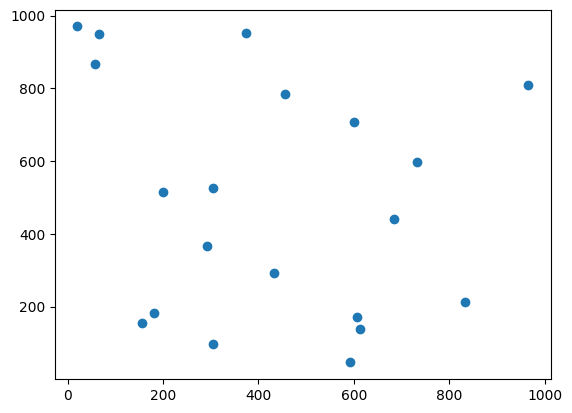

{'Greedy': {'instance': None, 'sequence': [0, 12, 4, 1, 19, 6, 15, 10, 14, 18, 7, 2, 11, 9, 8, 13, 3, 16, 5, 17, 0], 'distance (m)': 4650.384155596448, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': None, 'sequence': [15, 10, 14, 9, 11, 8, 13, 7, 18, 2, 3, 16, 5, 0, 12, 4, 1, 17, 19, 6, 15], 'distance (m)': 4483.337255548596, 'time (ns)': 1000300, 'num_dests': 19}, 'OR Tools': {'instance': None, 'sequence': [0, 16, 5, 3, 13, 8, 11, 9, 7, 2, 18, 14, 10, 15, 6, 19, 1, 17, 4, 12, 0], 'distance (m)': 3866.266770061002, 'time (ns)': 8505200, 'num_dests': 19}, 'Dynamic Programming': {'instance': None, 'sequence': -1, 'distance (m)': -1, 'time (ns)': 0, 'num_dests': 19}}


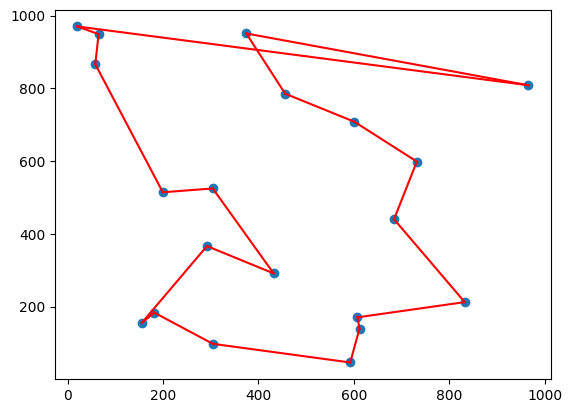

Greedy - Length: 4650.384155596448
Greedy - Time: 0 ns



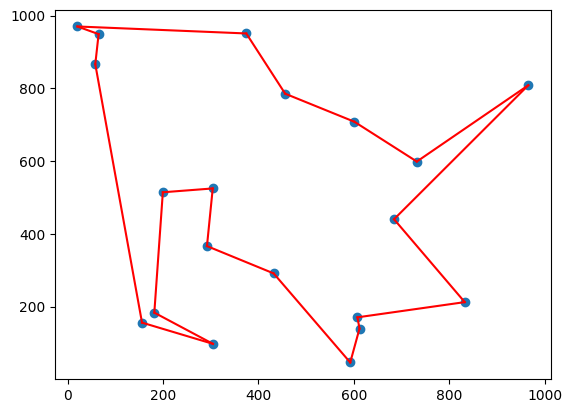

Christofides - Length: 4483.337255548596
Christofides - Time: 1000300 ns



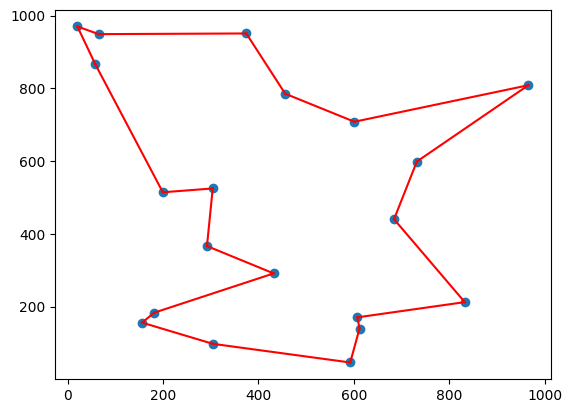

OR Tools - Length: 3866.266770061002
OR Tools - Time: 8505200 ns

Dynamic Programming - No solution found
Dynamic Programming - Time: 0 ns



In [14]:
def main():
    n = 20
    seed = 42
    sample_points = generate_random_points(n, seed)
    distance_matrix = generate_distance_matrix(sample_points)

    solvers = {
        'Greedy': greedy,
        'Christofides': christofides,
        'OR Tools': or_tools,
        'Dynamic Programming': dynamic_prog,
    }

    results = evaluate(solvers, distance_matrix)

    plot_results(sample_points, results, distance_matrix)

main()

## Executing Solvers on all Problem Instances

In [15]:
from pathlib import Path
import glob
from tqdm.notebook import tqdm

In [16]:
res = glob.glob("../processed_heuristic-threshold/instances/1/*/*")
print(res)

['../processed_heuristic-threshold/instances/1\\1\\ds_1002_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1002_courier_967', '../processed_heuristic-threshold/instances/1\\1\\ds_1003_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1005_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1007_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1007_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1008_courier_967', '../processed_heuristic-threshold/instances/1\\1\\ds_1014_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1015_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1019_courier_1520', '../processed_heuristic-threshold/instances/1\\1\\ds_1020_courier_1558', '../processed_heuristic-threshold/instances/1\\1\\ds_1021_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1021_courier_87', '../processed_heuristic-threshold/instances/1\\1\\ds_1022_c

In [17]:
def run_solvers(file_path, solvers):
    path = Path(file_path)
    print(path)
    
    result = None
    if path.is_dir():
    
        with np.load(path / 'pairwise.npz') as data:
            dist_matrix = data["arr_0"]

        num_dest = dist_matrix.shape[0] - 1

        result = evaluate(solvers, dist_matrix, path.name, num_dests=num_dest)
        print(result, end="\n\n")

    return result

In [18]:
def generate_solver_df(file_paths):
    solvers = {
    'Greedy': greedy,
    'Christofides': christofides,
    'OR Tools': or_tools,
    # 'Dynamic Programming': dynamic_prog,
    }

    greedy_results = []
    christofides_results = []
    or_tools_results = []
    # dynamic_prog_results = []

    for path in tqdm(file_paths):
        result = run_solvers(path, solvers)
        print(result)
        
        for key, value in result.items():
            if key == "Greedy":
                greedy_results.append(value)
            elif key == "Christofides":
                christofides_results.append(value)
            elif key == "OR Tools":
                or_tools_results.append(value)
            # elif key == "Dynamic Programming":
            #     dynamic_prog_results.append(value)
    
    greedy_df = pd.DataFrame(greedy_results)
    christofides_df = pd.DataFrame(christofides_results)
    or_tools_df = pd.DataFrame(or_tools_results)
    # dynamic_prog_df = pd.DataFrame(dynamic_prog_results)

    greedy_df.to_csv("../results/greedy_results.csv", index=False)
    christofides_df.to_csv("../results/christofides_results.csv", index=False)
    or_tools_df.to_csv("../results/or_tools_results.csv", index=False)
    # dynamic_prog_df.to_csv("../results/dynamic_prog_results.csv", index=False)

    return greedy_df, christofides_df, or_tools_df, #dynamic_prog_df

In [19]:
generate_solver_df(res)

  0%|          | 0/1492 [00:00<?, ?it/s]

..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_218
{'Greedy': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'Christofides': {'instance': 'ds_1002_courier_218', 'sequence': [1, 0, 1], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'OR Tools': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 1001600, 'num_dests': 1}}

{'Greedy': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'Christofides': {'instance': 'ds_1002_courier_218', 'sequence': [1, 0, 1], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'OR Tools': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 1001600, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_967
{'Greedy': {'

(                 instance                           sequence  distance (m)  \
 0     ds_1002_courier_218                          [0, 1, 0]   7438.872931   
 1     ds_1002_courier_967                          [0, 1, 0]  25531.317263   
 2     ds_1003_courier_218                          [0, 1, 0]     51.357485   
 3     ds_1005_courier_218                          [0, 1, 0]     44.871429   
 4     ds_1007_courier_218                          [0, 1, 0]     33.865249   
 ...                   ...                                ...           ...   
 1487  ds_910_courier_1558  [0, 5, 4, 1, 2, 3, 6, 7, 8, 9, 0]   8089.747437   
 1488   ds_919_courier_487  [0, 3, 4, 5, 6, 1, 9, 2, 7, 8, 0]  17477.600058   
 1489  ds_920_courier_1656  [0, 3, 4, 5, 2, 8, 6, 7, 9, 1, 0]  20958.354404   
 1490   ds_920_courier_487  [0, 4, 6, 7, 1, 2, 5, 9, 3, 8, 0]  17844.073068   
 1491   ds_926_courier_487  [0, 8, 7, 6, 4, 5, 2, 9, 1, 3, 0]  17937.683222   
 
       time (ns)  num_dests  
 0             0    

In [20]:
def generate_solver_df(file_paths):
    solvers = {
    # 'Greedy': greedy,
    # 'Christofides': christofides,
    # 'OR Tools': or_tools,
    'Dynamic Programming': dynamic_prog,
    }

    greedy_results = []
    christofides_results = []
    or_tools_results = []
    dynamic_prog_results = []

    for path in tqdm(file_paths):
        result = run_solvers(path, solvers)
        print(result)
        
        for key, value in result.items():
            if key == "Greedy":
                greedy_results.append(value)
            elif key == "Christofides":
                christofides_results.append(value)
            elif key == "OR Tools":
                or_tools_results.append(value)
            elif key == "Dynamic Programming":
                dynamic_prog_results.append(value)
    
    # greedy_df = pd.DataFrame(greedy_results)
    # christofides_df = pd.DataFrame(christofides_results)
    # or_tools_df = pd.DataFrame(or_tools_results)
    dynamic_prog_df = pd.DataFrame(dynamic_prog_results)

    # greedy_df.to_csv("greedy_results.csv", index=False)
    # christofides_df.to_csv("christofides_results.csv", index=False)
    # or_tools_df.to_csv("or_tools_results.csv", index=False)
    dynamic_prog_df.to_csv("../results/dynamic_prog_results.csv", index=False)

    return dynamic_prog_df

In [28]:
generate_solver_df(res)

  0%|          | 0/1492 [00:00<?, ?it/s]

..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_218
{'Dynamic Programming': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_967
{'Dynamic Programming': {'instance': 'ds_1002_courier_967', 'sequence': [0, 1, 0], 'distance (m)': 25531.31726272752, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds_1002_courier_967', 'sequence': [0, 1, 0], 'distance (m)': 25531.31726272752, 'time (ns)': 0, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1003_courier_218
{'Dynamic Programming': {'instance': 'ds_1003_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 51.357484715009626, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds

### Import Results from CSV

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
RESULTS_DIR = "../results"

CHRISTOFIDES = RESULTS_DIR + "/christofides_results.csv"
DYNAMIC_PROG = RESULTS_DIR + "/dynamic_prog_results.csv"
OR_TOOLS = RESULTS_DIR + "/or_tools_results.csv"
GREEDY = RESULTS_DIR + "/greedy_results.csv"
GNN_v1 = RESULTS_DIR + "/gnn_v1_results.csv"

In [ ]:
def load_results(file_path):
    return pd.read_csv(file_path)

def str_to_list(row):
    import ast
    if row == "-1":
        return -1
    else:
        ndarray = row.strip('][').split(', ')
        return ndarray

In [ ]:
christofides_df = load_results(CHRISTOFIDES).sort_values(by="instance").reset_index(drop=True)
or_tools_df = load_results(OR_TOOLS).sort_values(by="instance").reset_index(drop=True)
greedy_df = load_results(GREEDY).sort_values(by="instance").reset_index(drop=True)
# gnn_v1_df = load_results(GNN_v1).sort_values(by="instance").reset_index(drop=True)
# dynamic_prog_df = load_results(DYNAMIC_PROG).sort_values(by="instance").reset_index(drop=True)

In [ ]:
christofides_df["sequence"] = christofides_df["sequence"].apply(str_to_list)
or_tools_df["sequence"] = or_tools_df["sequence"].apply(str_to_list)
greedy_df["sequence"] = greedy_df["sequence"].apply(str_to_list)
# gnn_v1_df["sequence"] = gnn_v1_df["sequence"].apply(str_to_list)
# dynamic_prog_df["sequence"] = dynamic_prog_df["sequence"].apply(str_to_list)

In [ ]:
christofides_df = christofides_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})
or_tools_df = or_tools_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})
greedy_df = greedy_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})
# gnn_v1_df = gnn_v1_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})
# dynamic_prog_df = dynamic_prog_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64})

In [ ]:
print(christofides_df.dtypes)
print(or_tools_df.dtypes)
print(greedy_df.dtypes)
# print(gnn_v1_df.dtypes)
# print(dynamic_prog_df.dtypes)

instance         object
sequence         object
distance (m)    float64
time (ns)         int64
num_dests         int64
dtype: object
instance         object
sequence         object
distance (m)    float64
time (ns)         int64
num_dests         int64
dtype: object
instance         object
sequence         object
distance (m)    float64
time (ns)         int64
num_dests         int64
dtype: object


In [ ]:
# dynamic_prog_df["sequence"] = dynamic_prog_df["sequence"].apply(str_to_array)

# print(christofides_df.iloc[0, 2].dtype)

In [ ]:
christofides_df.rename(columns={"sequence": "christofides_sequence", "distance (m)": "christofides_distance", "time (ns)": "christofides_time"}, inplace=True)
display(christofides_df)

,instance,christofides_sequence,christofides_distance,christofides_time,num_dests
0,ds_1001_courier_1103,"[20, 19, 18, 14, 17, 21, 16, 9, 10, 8, 2, 1, 6...",18183.561026,1000100,21
1,ds_1001_courier_1520,"[17, 13, 12, 0, 1, 2, 24, 4, 28, 19, 8, 25, 9,...",10606.932572,1000200,29
2,ds_1001_courier_1656,"[14, 0, 3, 6, 11, 7, 12, 4, 13, 10, 2, 8, 5, 9...",18271.775192,0,14
3,ds_1001_courier_2688,"[13, 7, 6, 17, 21, 15, 20, 14, 18, 16, 11, 12,...",12319.695908,0,21
4,ds_1001_courier_2945,"[7, 6, 14, 5, 11, 12, 13, 10, 15, 16, 17, 18, ...",13876.853971,1000100,27
...,...,...,...,...,...
1487,ds_930_courier_290,"[5, 4, 7, 12, 9, 6, 3, 10, 1, 11, 8, 2, 0, 14,...",8991.205735,1003300,14
1488,ds_930_courier_435,"[11, 3, 15, 6, 7, 2, 4, 14, 10, 9, 1, 12, 5, 0...",9531.613523,0,15
1489,ds_930_courier_4474,"[10, 8, 7, 2, 4, 6, 3, 20, 0, 1, 18, 17, 15, 1...",10050.555805,1000200,20
1490,ds_930_courier_487,"[11, 10, 12, 8, 9, 0, 7, 6, 5, 3, 4, 1, 14, 2,...",16594.787701,0,14


In [ ]:
or_tools_df.rename(columns={"sequence": "or_tools_sequence", "distance (m)": "or_tools_distance", "time (ns)": "or_tools_time"}, inplace=True)
display(or_tools_df)

,instance,or_tools_sequence,or_tools_distance,or_tools_time,num_dests
0,ds_1001_courier_1103,"[0, 15, 21, 20, 19, 18, 14, 17, 16, 9, 10, 8, ...",17324.195317,12007500,21
1,ds_1001_courier_1520,"[0, 12, 13, 17, 22, 7, 21, 3, 27, 20, 11, 18, ...",8341.080239,26520400,29
2,ds_1001_courier_1656,"[0, 14, 3, 6, 11, 7, 9, 13, 10, 4, 12, 5, 8, 2...",17292.137023,5152600,14
3,ds_1001_courier_2688,"[0, 19, 16, 18, 15, 21, 17, 10, 2, 3, 5, 4, 8,...",11047.248526,7002500,21
4,ds_1001_courier_2945,"[0, 24, 3, 4, 1, 2, 20, 21, 22, 25, 23, 9, 18,...",12696.919432,12809900,27
...,...,...,...,...,...
1487,ds_930_courier_290,"[0, 14, 2, 8, 6, 3, 10, 1, 11, 12, 9, 7, 4, 5,...",8666.253003,3004600,14
1488,ds_930_courier_435,"[0, 13, 12, 9, 1, 14, 2, 4, 10, 8, 11, 3, 7, 1...",9024.117062,6518400,15
1489,ds_930_courier_4474,"[0, 9, 5, 10, 8, 7, 2, 1, 11, 19, 12, 16, 13, ...",8634.285049,5504300,20
1490,ds_930_courier_487,"[0, 7, 6, 5, 3, 4, 2, 14, 1, 13, 11, 10, 8, 9,...",15814.126768,3000000,14


In [ ]:
greedy_df.rename(columns={"sequence": "greedy_sequence", "distance (m)": "greedy_distance", "time (ns)": "greedy_time"}, inplace=True)
display(greedy_df)

,instance,greedy_sequence,greedy_distance,greedy_time,num_dests
0,ds_1001_courier_1103,"[0, 13, 12, 11, 15, 20, 19, 21, 18, 14, 17, 7,...",20129.150350,0,21
1,ds_1001_courier_1520,"[0, 1, 12, 17, 13, 22, 7, 21, 3, 27, 20, 4, 28...",9609.178661,0,29
2,ds_1001_courier_1656,"[0, 14, 1, 6, 11, 7, 12, 4, 13, 9, 5, 8, 2, 10...",19079.531559,0,14
3,ds_1001_courier_2688,"[0, 19, 12, 11, 16, 18, 15, 20, 14, 21, 17, 6,...",12691.013943,0,21
4,ds_1001_courier_2945,"[0, 24, 3, 4, 1, 2, 20, 21, 22, 25, 23, 26, 19...",13372.186482,0,27
...,...,...,...,...,...
1487,ds_930_courier_290,"[0, 14, 2, 8, 6, 3, 10, 1, 11, 12, 7, 4, 5, 13...",8871.835625,0,14
1488,ds_930_courier_435,"[0, 13, 12, 5, 8, 11, 3, 7, 15, 6, 9, 1, 10, 4...",9985.032204,0,15
1489,ds_930_courier_4474,"[0, 2, 7, 8, 10, 5, 9, 1, 18, 17, 15, 16, 14, ...",9228.206103,0,20
1490,ds_930_courier_487,"[0, 7, 6, 5, 3, 1, 14, 2, 4, 13, 11, 10, 12, 8...",16434.215974,0,14


In [ ]:
# gnn_v1_df.rename(columns={"sequence": "gnn_sequence", "distance (m)": "gnn_distance", "time (ns)": "gnn_time"}, inplace=True)
# display(gnn_v1_df)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf2edc64-aead-4b81-a3fd-24d0376819e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [ ]:
# dynamic_prog_df.rename(columns={"sequence": "dynamic_prog_sequence", "distance (m)": "dynamic_prog_distance", "time (ns)": "dynamic_prog_time"}, inplace=True)
# display(dynamic_prog_df)

In [ ]:
combined_df = pd.concat([or_tools_df, greedy_df, christofides_df], axis=1)
combined_df = combined_df.loc[:,~combined_df.columns.duplicated()]
display(combined_df)

,instance,or_tools_sequence,or_tools_distance,or_tools_time,num_dests,greedy_sequence,greedy_distance,greedy_time,christofides_sequence,christofides_distance,christofides_time
0,ds_1001_courier_1103,"[0, 15, 21, 20, 19, 18, 14, 17, 16, 9, 10, 8, ...",17324.195317,12007500,21,"[0, 13, 12, 11, 15, 20, 19, 21, 18, 14, 17, 7,...",20129.150350,0,"[20, 19, 18, 14, 17, 21, 16, 9, 10, 8, 2, 1, 6...",18183.561026,1000100
1,ds_1001_courier_1520,"[0, 12, 13, 17, 22, 7, 21, 3, 27, 20, 11, 18, ...",8341.080239,26520400,29,"[0, 1, 12, 17, 13, 22, 7, 21, 3, 27, 20, 4, 28...",9609.178661,0,"[17, 13, 12, 0, 1, 2, 24, 4, 28, 19, 8, 25, 9,...",10606.932572,1000200
2,ds_1001_courier_1656,"[0, 14, 3, 6, 11, 7, 9, 13, 10, 4, 12, 5, 8, 2...",17292.137023,5152600,14,"[0, 14, 1, 6, 11, 7, 12, 4, 13, 9, 5, 8, 2, 10...",19079.531559,0,"[14, 0, 3, 6, 11, 7, 12, 4, 13, 10, 2, 8, 5, 9...",18271.775192,0
3,ds_1001_courier_2688,"[0, 19, 16, 18, 15, 21, 17, 10, 2, 3, 5, 4, 8,...",11047.248526,7002500,21,"[0, 19, 12, 11, 16, 18, 15, 20, 14, 21, 17, 6,...",12691.013943,0,"[13, 7, 6, 17, 21, 15, 20, 14, 18, 16, 11, 12,...",12319.695908,0
4,ds_1001_courier_2945,"[0, 24, 3, 4, 1, 2, 20, 21, 22, 25, 23, 9, 18,...",12696.919432,12809900,27,"[0, 24, 3, 4, 1, 2, 20, 21, 22, 25, 23, 26, 19...",13372.186482,0,"[7, 6, 14, 5, 11, 12, 13, 10, 15, 16, 17, 18, ...",13876.853971,1000100
...,...,...,...,...,...,...,...,...,...,...,...
1487,ds_930_courier_290,"[0, 14, 2, 8, 6, 3, 10, 1, 11, 12, 9, 7, 4, 5,...",8666.253003,3004600,14,"[0, 14, 2, 8, 6, 3, 10, 1, 11, 12, 7, 4, 5, 13...",8871.835625,0,"[5, 4, 7, 12, 9, 6, 3, 10, 1, 11, 8, 2, 0, 14,...",8991.205735,1003300
1488,ds_930_courier_435,"[0, 13, 12, 9, 1, 14, 2, 4, 10, 8, 11, 3, 7, 1...",9024.117062,6518400,15,"[0, 13, 12, 5, 8, 11, 3, 7, 15, 6, 9, 1, 10, 4...",9985.032204,0,"[11, 3, 15, 6, 7, 2, 4, 14, 10, 9, 1, 12, 5, 0...",9531.613523,0
1489,ds_930_courier_4474,"[0, 9, 5, 10, 8, 7, 2, 1, 11, 19, 12, 16, 13, ...",8634.285049,5504300,20,"[0, 2, 7, 8, 10, 5, 9, 1, 18, 17, 15, 16, 14, ...",9228.206103,0,"[10, 8, 7, 2, 4, 6, 3, 20, 0, 1, 18, 17, 15, 1...",10050.555805,1000200
1490,ds_930_courier_487,"[0, 7, 6, 5, 3, 4, 2, 14, 1, 13, 11, 10, 8, 9,...",15814.126768,3000000,14,"[0, 7, 6, 5, 3, 1, 14, 2, 4, 13, 11, 10, 12, 8...",16434.215974,0,"[11, 10, 12, 8, 9, 0, 7, 6, 5, 3, 4, 1, 14, 2,...",16594.787701,0


In [ ]:
eval_dist_df = combined_df[["instance", "num_dests", "or_tools_distance", "greedy_distance", "christofides_distance"]]
eval_time_df = combined_df[["instance", "num_dests", "or_tools_time", "greedy_time", "christofides_time"]]

In [ ]:
display(eval_dist_df)

,instance,num_dests,or_tools_distance,greedy_distance,christofides_distance
0,ds_1001_courier_1103,21,17324.195317,20129.150350,18183.561026
1,ds_1001_courier_1520,29,8341.080239,9609.178661,10606.932572
2,ds_1001_courier_1656,14,17292.137023,19079.531559,18271.775192
3,ds_1001_courier_2688,21,11047.248526,12691.013943,12319.695908
4,ds_1001_courier_2945,27,12696.919432,13372.186482,13876.853971
...,...,...,...,...,...
1487,ds_930_courier_290,14,8666.253003,8871.835625,8991.205735
1488,ds_930_courier_435,15,9024.117062,9985.032204,9531.613523
1489,ds_930_courier_4474,20,8634.285049,9228.206103,10050.555805
1490,ds_930_courier_487,14,15814.126768,16434.215974,16594.787701


In [ ]:
def compute_optimality_gap(df, optimal_col, other_cols):
    for col in other_cols:
        df[f"{col}_gap"] = (df[col] - df[optimal_col]) / df[optimal_col] * 100
    return df

In [ ]:
eval_dist_df["min_distance"] = eval_dist_df[["or_tools_distance", "greedy_distance", "christofides_distance"]].min(axis=1)
eval_dist_df["min_distance_solver"] = eval_dist_df[["or_tools_distance", "greedy_distance", "christofides_distance"]].idxmin(axis=1)
eval_dist_df = compute_optimality_gap(eval_dist_df, "min_distance", ["or_tools_distance", "greedy_distance", "christofides_distance"])
display(eval_dist_df)

C:\Users\User\AppData\Local\Temp\ipykernel_34360\3751670607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_dist_df["min_distance"] = eval_dist_df[["or_tools_distance", "greedy_distance", "christofides_distance"]].min(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_34360\3751670607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_dist_df["min_distance_solver"] = eval_dist_df[["or_tools_distance", "greedy_distance", "christofides_distance"]].idxmin(axis=1)
C:\Users\User\AppData\Local\Temp

,instance,num_dests,or_tools_distance,greedy_distance,christofides_distance,min_distance,min_distance_solver,or_tools_distance_gap,greedy_distance_gap,christofides_distance_gap
0,ds_1001_courier_1103,21,17324.195317,20129.150350,18183.561026,17324.195317,or_tools_distance,0.0,16.190969,4.960494
1,ds_1001_courier_1520,29,8341.080239,9609.178661,10606.932572,8341.080239,or_tools_distance,0.0,15.203048,27.164975
2,ds_1001_courier_1656,14,17292.137023,19079.531559,18271.775192,17292.137023,or_tools_distance,0.0,10.336458,5.665223
3,ds_1001_courier_2688,21,11047.248526,12691.013943,12319.695908,11047.248526,or_tools_distance,0.0,14.879410,11.518229
4,ds_1001_courier_2945,27,12696.919432,13372.186482,13876.853971,12696.919432,or_tools_distance,0.0,5.318353,9.293077
...,...,...,...,...,...,...,...,...,...,...
1487,ds_930_courier_290,14,8666.253003,8871.835625,8991.205735,8666.253003,or_tools_distance,0.0,2.372220,3.749634
1488,ds_930_courier_435,15,9024.117062,9985.032204,9531.613523,9024.117062,or_tools_distance,0.0,10.648301,5.623780
1489,ds_930_courier_4474,20,8634.285049,9228.206103,10050.555805,8634.285049,or_tools_distance,0.0,6.878636,16.402872
1490,ds_930_courier_487,14,15814.126768,16434.215974,16594.787701,15814.126768,or_tools_distance,0.0,3.921109,4.936478


In [ ]:
avg_dist_df = eval_dist_df[["num_dests", "or_tools_distance_gap", "greedy_distance_gap", "christofides_distance_gap"]].groupby("num_dests")
display(avg_dist_df.mean().round(3))

,or_tools_distance_gap,greedy_distance_gap,christofides_distance_gap
num_dests,,,
1,0.000,0.000,0.000
2,0.000,0.000,0.000
3,0.000,0.900,0.970
4,0.000,2.625,2.572
5,0.000,3.447,2.049
6,0.000,2.855,3.329
7,0.000,5.170,4.410
8,0.000,5.858,4.758
9,0.100,7.577,7.317


In [ ]:
eval_time_df["min_time"] = eval_time_df[["or_tools_time", "greedy_time", "christofides_time"]].min(axis=1)
eval_time_df["min_time_solver"] = eval_time_df[["or_tools_time", "greedy_time", "christofides_time"]].idxmin(axis=1)
eval_time_df = compute_optimality_gap(eval_time_df, "min_time", ["or_tools_time", "greedy_time", "christofides_time"])
display(eval_time_df)

C:\Users\User\AppData\Local\Temp\ipykernel_34360\4036992513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_time_df["min_time"] = eval_time_df[["or_tools_time", "greedy_time", "christofides_time"]].min(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_34360\4036992513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_time_df["min_time_solver"] = eval_time_df[["or_tools_time", "greedy_time", "christofides_time"]].idxmin(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_34360\2126328468.py:3

,instance,num_dests,or_tools_time,greedy_time,christofides_time,min_time,min_time_solver,or_tools_time_gap,greedy_time_gap,christofides_time_gap
0,ds_1001_courier_1103,21,12007500,0,1000100,0,greedy_time,inf,NaN,inf
1,ds_1001_courier_1520,29,26520400,0,1000200,0,greedy_time,inf,NaN,inf
2,ds_1001_courier_1656,14,5152600,0,0,0,greedy_time,inf,NaN,NaN
3,ds_1001_courier_2688,21,7002500,0,0,0,greedy_time,inf,NaN,NaN
4,ds_1001_courier_2945,27,12809900,0,1000100,0,greedy_time,inf,NaN,inf
...,...,...,...,...,...,...,...,...,...,...
1487,ds_930_courier_290,14,3004600,0,1003300,0,greedy_time,inf,NaN,inf
1488,ds_930_courier_435,15,6518400,0,0,0,greedy_time,inf,NaN,NaN
1489,ds_930_courier_4474,20,5504300,0,1000200,0,greedy_time,inf,NaN,inf
1490,ds_930_courier_487,14,3000000,0,0,0,greedy_time,inf,NaN,NaN


In [ ]:
avg_time_df = eval_time_df[["num_dests", "or_tools_time_gap", "greedy_time_gap", "christofides_time_gap"]].groupby("num_dests")
display(avg_time_df.mean().round(3))

,or_tools_time_gap,greedy_time_gap,christofides_time_gap
num_dests,,,
1,inf,NaN,inf
2,inf,inf,NaN
3,inf,NaN,inf
4,inf,NaN,NaN
5,inf,inf,inf
6,inf,NaN,inf
7,inf,NaN,inf
8,inf,inf,inf
9,inf,NaN,inf
